In [1]:
"""Setup for Fused_ZS6D"""
stride = 14
image_size_sd = 960
image_size_dino = 840
layer = 11
facet = 'token'
model_type = 'dinov2_vitb14'

In [2]:
from zs6d_sd_dino.sd_dino.extractor_sd import load_model

# Instantiating the stable diffusion model:
model_sd, aug_sd = load_model(diffusion_ver="v1-5", image_size=image_size_sd, num_timesteps=100)


A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


LatentDiffusion: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, con

/home/berni/anaconda3/envs/zs6d_sd_dino/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
The checkpoint state_dict contains keys that are not used by the model:
  model_ema.{decay, num_updates}
backbone.feature_extractor.,category_head.clip.clip.,clip_head.clip.clip.
backbone.feature_projections.2.0.conv1.weight
backbone.feature_projections.2.0.shortcut.weight
backbone.feature_projections.3.0.conv1.weight
backbone.feature_projections.3.0.shortcut.weight
backbone.feature_projections.4.0.conv1.weight
backbone.feature_projections.4.0.shortcut.weight
backbone.feature_projections.5.0.conv1.weight
backbone.feature_projections.5.0.shortcut.weight


In [3]:
from zs6dsddino import ZS6DSdDino
import os
import json



# Loading the config file:
with open(os.path.join("./zs6d_configs/bop_eval_configs/cfg_single_sd_dino.json"), "r") as f:
    config = json.load(f)
    
# Instantiating the pose estimator:
# This involves handing over the path to the templates_gt file and the corresponding object norm_factors.
pose_estimator_sd_dino = ZS6DSdDino(model_sd, aug_sd, image_size_dino, image_size_sd, layer, facet, config['templates_gt_path'], config['norm_factor_path'], model_type=model_type, stride=stride)


Using cache found in /home/berni/.cache/torch/hub/facebookresearch_dinov2_main
/home/berni/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/berni/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/berni/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
100%|██████████| 1/1 [01:10<00:00, 70.97s/it]


Shape of SD features: torch.Size([1, 1, 3600, 384])
Shape of DINO features: torch.Size([1, 1, 3600, 768])
Shape of SD-DINO features: torch.Size([1, 1, 3600, 1152])


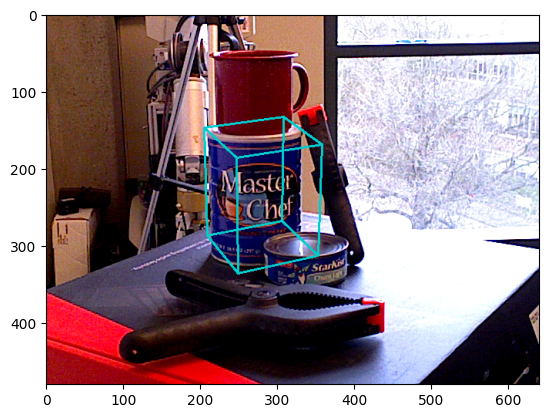

Pose estimation time: 8.248219728469849
R_est: [[ 0.90742543 -0.41999752  0.0134604 ]
 [-0.16382427 -0.38308501 -0.90906957]
 [ 0.38696344  0.8227077  -0.41642687]]
t_est: [-30.02965675  -8.91099784 965.61081236]


ERROR:ZS6DSdDino:Error in get_pose: '6'


Shape of SD features: torch.Size([1, 1, 3600, 384])
Shape of DINO features: torch.Size([1, 1, 3600, 768])
Shape of SD-DINO features: torch.Size([1, 1, 3600, 1152])


KeyError: '6'

In [4]:
import cv2
from PIL import Image
import pose_utils.img_utils as img_utils
import pose_utils.vis_utils as vis_utils
import numpy as np
import time
import matplotlib.pyplot as plt
import torch


# Loading a ground truth file to access segmentation masks to test zs6d:
with open(os.path.join(config['gt_path']), 'r') as f:
    data_gt = json.load(f)

img_id = '000048_1'
# img_id = '8'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

patch_size = 14 #extractor.model.patch_embed.patch_size[0]
num_patches = int(patch_size / stride * (image_size_dino // patch_size))


for i in range(len(data_gt[img_id])):
    obj_number = i
    obj_id = data_gt[img_id][obj_number]['obj_id']
    cam_K = np.array(data_gt[img_id][obj_number]['cam_K']).reshape((3,3))
    bbox = data_gt[img_id][obj_number]['bbox_visib']

    img_path = "./test/000001.png"
    img = Image.open(img_path)

    mask = data_gt[img_id][obj_number]['mask_sam']
    mask = img_utils.rle_to_mask(mask)
    mask = mask.astype(np.uint8)

    start_time = time.time()
    
    # To estimate the objects Rotation R and translation t the input image, the object_id, a segmentation mask and camera matrix are necessary
    R_est, t_est = pose_estimator_sd_dino.get_pose(num_patches, img, str(obj_id), mask, cam_K, bbox=None)

    end_time = time.time()
    
    out_img = vis_utils.draw_3D_bbox_on_image(np.array(img), R_est, t_est, cam_K, data_gt[img_id][obj_number]['model_info'], factor=1.0)

    plt.imshow(out_img)
    plt.show()
    print(f"Pose estimation time: {end_time-start_time}")
    print(f"R_est: {R_est}")
    print(f"t_est: {t_est}")